# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [39]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

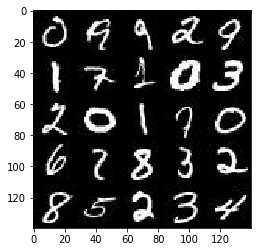

In [40]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

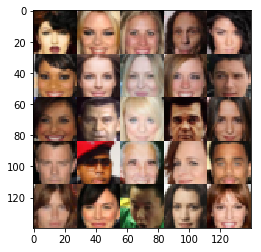

In [41]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [42]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [43]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [44]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # 28*28*3
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        relu1 = tf.maximum(0.01 * x1, x1)
        # 14*14*128
        
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(0.01 * bn2, bn2)
        # 7*7*256

        x3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same')
        n3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(0.01 * n3, n3)
        #4x4x512
        
        # Flatten it
        flat = tf.contrib.layers.flatten(relu3)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [45]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(0.01 * x1, x1)
        # 7x7x512 now

        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.01 * x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training = is_train)
        x3 = tf.maximum(0.01 * x3, x3)
        # 28x28x128 now

        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x3 now

        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [46]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [47]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [48]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [49]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    steps = 0
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height,image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z,image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    is_train = tf.placeholder(tf.bool)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_z = batch_z*2

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 50, input_z, image_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0829... Generator Loss: 3.2052
Epoch 1/2... Discriminator Loss: 0.6541... Generator Loss: 9.2547
Epoch 1/2... Discriminator Loss: 0.3756... Generator Loss: 1.9930
Epoch 1/2... Discriminator Loss: 1.5829... Generator Loss: 0.3736
Epoch 1/2... Discriminator Loss: 1.4671... Generator Loss: 0.4917
Epoch 1/2... Discriminator Loss: 1.4713... Generator Loss: 0.3693
Epoch 1/2... Discriminator Loss: 1.3716... Generator Loss: 0.3931
Epoch 1/2... Discriminator Loss: 1.1150... Generator Loss: 0.5228
Epoch 1/2... Discriminator Loss: 1.0347... Generator Loss: 0.5879
Epoch 1/2... Discriminator Loss: 1.2177... Generator Loss: 0.4402


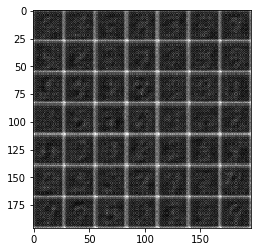

Epoch 1/2... Discriminator Loss: 1.0757... Generator Loss: 0.5062
Epoch 1/2... Discriminator Loss: 0.9523... Generator Loss: 0.6274
Epoch 1/2... Discriminator Loss: 0.3760... Generator Loss: 1.5214
Epoch 1/2... Discriminator Loss: 0.4437... Generator Loss: 3.0470
Epoch 1/2... Discriminator Loss: 0.2750... Generator Loss: 1.9648
Epoch 1/2... Discriminator Loss: 0.1988... Generator Loss: 2.3788
Epoch 1/2... Discriminator Loss: 0.1345... Generator Loss: 2.9234
Epoch 1/2... Discriminator Loss: 0.1262... Generator Loss: 2.8872
Epoch 1/2... Discriminator Loss: 0.1344... Generator Loss: 3.3586
Epoch 1/2... Discriminator Loss: 0.1069... Generator Loss: 3.1839


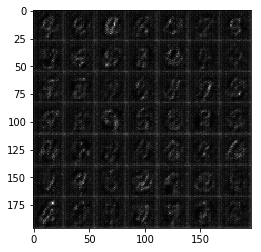

Epoch 1/2... Discriminator Loss: 0.0761... Generator Loss: 3.2457
Epoch 1/2... Discriminator Loss: 0.0766... Generator Loss: 3.6967
Epoch 1/2... Discriminator Loss: 0.0621... Generator Loss: 3.5230
Epoch 1/2... Discriminator Loss: 0.0695... Generator Loss: 3.3853
Epoch 1/2... Discriminator Loss: 0.0497... Generator Loss: 3.5916
Epoch 1/2... Discriminator Loss: 0.0754... Generator Loss: 3.6810
Epoch 1/2... Discriminator Loss: 0.0175... Generator Loss: 5.4076
Epoch 1/2... Discriminator Loss: 0.0635... Generator Loss: 3.4242
Epoch 1/2... Discriminator Loss: 0.0431... Generator Loss: 4.3848
Epoch 1/2... Discriminator Loss: 0.6724... Generator Loss: 3.3209


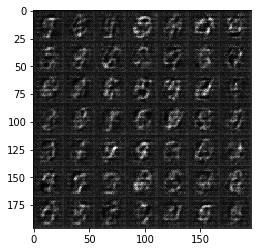

Epoch 1/2... Discriminator Loss: 0.3192... Generator Loss: 4.0837
Epoch 1/2... Discriminator Loss: 0.2097... Generator Loss: 1.9174
Epoch 1/2... Discriminator Loss: 0.0568... Generator Loss: 4.8293
Epoch 1/2... Discriminator Loss: 0.1658... Generator Loss: 2.2692
Epoch 1/2... Discriminator Loss: 0.1646... Generator Loss: 2.2298
Epoch 1/2... Discriminator Loss: 0.0823... Generator Loss: 3.0600
Epoch 1/2... Discriminator Loss: 0.1237... Generator Loss: 2.4435
Epoch 1/2... Discriminator Loss: 0.3016... Generator Loss: 1.5826
Epoch 1/2... Discriminator Loss: 0.5888... Generator Loss: 1.1009
Epoch 1/2... Discriminator Loss: 0.1082... Generator Loss: 3.1640


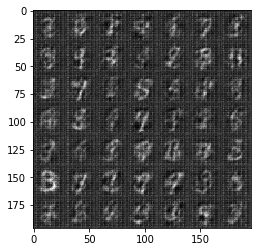

Epoch 1/2... Discriminator Loss: 0.0679... Generator Loss: 3.9633
Epoch 1/2... Discriminator Loss: 0.1919... Generator Loss: 3.7288
Epoch 1/2... Discriminator Loss: 0.0387... Generator Loss: 4.6283
Epoch 1/2... Discriminator Loss: 0.0533... Generator Loss: 4.9394
Epoch 1/2... Discriminator Loss: 0.0499... Generator Loss: 4.2227
Epoch 1/2... Discriminator Loss: 0.0302... Generator Loss: 5.9609
Epoch 2/2... Discriminator Loss: 0.1068... Generator Loss: 5.9156
Epoch 2/2... Discriminator Loss: 0.5593... Generator Loss: 3.2646
Epoch 2/2... Discriminator Loss: 0.7925... Generator Loss: 0.8189
Epoch 2/2... Discriminator Loss: 0.4108... Generator Loss: 1.4843


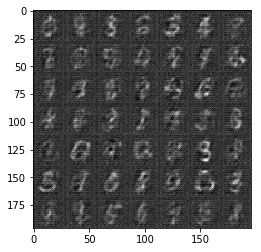

Epoch 2/2... Discriminator Loss: 0.7789... Generator Loss: 0.8402
Epoch 2/2... Discriminator Loss: 0.1344... Generator Loss: 3.2042
Epoch 2/2... Discriminator Loss: 0.2292... Generator Loss: 3.5041
Epoch 2/2... Discriminator Loss: 1.5009... Generator Loss: 6.7316
Epoch 2/2... Discriminator Loss: 0.2164... Generator Loss: 2.2034
Epoch 2/2... Discriminator Loss: 0.0904... Generator Loss: 3.2287
Epoch 2/2... Discriminator Loss: 0.0495... Generator Loss: 4.6806
Epoch 2/2... Discriminator Loss: 0.0688... Generator Loss: 3.3653
Epoch 2/2... Discriminator Loss: 0.1070... Generator Loss: 2.7429
Epoch 2/2... Discriminator Loss: 0.1431... Generator Loss: 2.3925


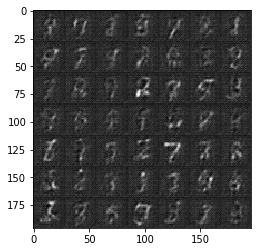

Epoch 2/2... Discriminator Loss: 0.0209... Generator Loss: 5.0630
Epoch 2/2... Discriminator Loss: 0.2837... Generator Loss: 1.6725
Epoch 2/2... Discriminator Loss: 0.0860... Generator Loss: 2.9781
Epoch 2/2... Discriminator Loss: 0.1954... Generator Loss: 2.1272
Epoch 2/2... Discriminator Loss: 0.0248... Generator Loss: 5.3826
Epoch 2/2... Discriminator Loss: 0.0493... Generator Loss: 5.4484
Epoch 2/2... Discriminator Loss: 0.0609... Generator Loss: 3.4454
Epoch 2/2... Discriminator Loss: 1.1663... Generator Loss: 0.5837
Epoch 2/2... Discriminator Loss: 0.7228... Generator Loss: 0.9403
Epoch 2/2... Discriminator Loss: 0.2340... Generator Loss: 2.0887


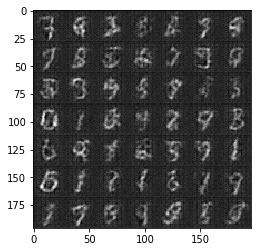

Epoch 2/2... Discriminator Loss: 0.2079... Generator Loss: 2.1105
Epoch 2/2... Discriminator Loss: 0.1782... Generator Loss: 2.2939
Epoch 2/2... Discriminator Loss: 0.1188... Generator Loss: 2.7232
Epoch 2/2... Discriminator Loss: 0.1270... Generator Loss: 2.6348
Epoch 2/2... Discriminator Loss: 0.1012... Generator Loss: 2.8280
Epoch 2/2... Discriminator Loss: 0.1291... Generator Loss: 2.5349
Epoch 2/2... Discriminator Loss: 0.1158... Generator Loss: 2.6804
Epoch 2/2... Discriminator Loss: 0.1127... Generator Loss: 2.6697
Epoch 2/2... Discriminator Loss: 0.3452... Generator Loss: 1.4725
Epoch 2/2... Discriminator Loss: 1.1789... Generator Loss: 0.4829


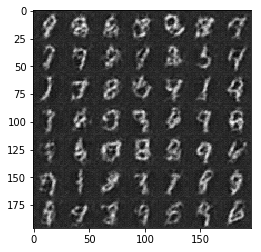

Epoch 2/2... Discriminator Loss: 0.8113... Generator Loss: 0.8010
Epoch 2/2... Discriminator Loss: 0.1958... Generator Loss: 2.2504
Epoch 2/2... Discriminator Loss: 0.1216... Generator Loss: 2.8092
Epoch 2/2... Discriminator Loss: 0.1611... Generator Loss: 2.4032
Epoch 2/2... Discriminator Loss: 0.1016... Generator Loss: 2.9278
Epoch 2/2... Discriminator Loss: 0.0872... Generator Loss: 3.0828
Epoch 2/2... Discriminator Loss: 0.1028... Generator Loss: 2.8236
Epoch 2/2... Discriminator Loss: 0.0415... Generator Loss: 4.2051
Epoch 2/2... Discriminator Loss: 0.0488... Generator Loss: 3.9990
Epoch 2/2... Discriminator Loss: 0.0315... Generator Loss: 4.7476


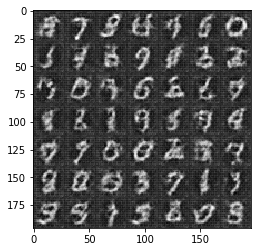

Epoch 2/2... Discriminator Loss: 0.0285... Generator Loss: 4.7665
Epoch 2/2... Discriminator Loss: 0.0760... Generator Loss: 6.2332
Epoch 2/2... Discriminator Loss: 0.8303... Generator Loss: 0.8872


In [50]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4654... Generator Loss: 1.2486
Epoch 1/1... Discriminator Loss: 0.1325... Generator Loss: 4.9498
Epoch 1/1... Discriminator Loss: 0.1284... Generator Loss: 7.7253
Epoch 1/1... Discriminator Loss: 0.0720... Generator Loss: 3.6051
Epoch 1/1... Discriminator Loss: 0.1570... Generator Loss: 2.8800
Epoch 1/1... Discriminator Loss: 0.1611... Generator Loss: 2.7869
Epoch 1/1... Discriminator Loss: 0.8911... Generator Loss: 1.3061
Epoch 1/1... Discriminator Loss: 0.3666... Generator Loss: 1.5554
Epoch 1/1... Discriminator Loss: 0.2459... Generator Loss: 1.9207
Epoch 1/1... Discriminator Loss: 0.0734... Generator Loss: 3.3473


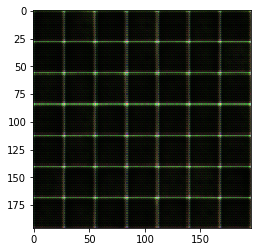

Epoch 1/1... Discriminator Loss: 0.1006... Generator Loss: 3.6982
Epoch 1/1... Discriminator Loss: 0.0283... Generator Loss: 5.5795
Epoch 1/1... Discriminator Loss: 0.0423... Generator Loss: 7.5983
Epoch 1/1... Discriminator Loss: 0.0982... Generator Loss: 2.9357
Epoch 1/1... Discriminator Loss: 0.0864... Generator Loss: 3.1629
Epoch 1/1... Discriminator Loss: 0.0540... Generator Loss: 3.5044
Epoch 1/1... Discriminator Loss: 0.0236... Generator Loss: 8.3321
Epoch 1/1... Discriminator Loss: 0.0193... Generator Loss: 4.8479
Epoch 1/1... Discriminator Loss: 0.0874... Generator Loss: 4.1833
Epoch 1/1... Discriminator Loss: 0.0193... Generator Loss: 4.9159


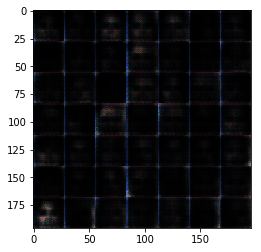

Epoch 1/1... Discriminator Loss: 0.1980... Generator Loss: 1.9878
Epoch 1/1... Discriminator Loss: 0.0210... Generator Loss: 9.1022
Epoch 1/1... Discriminator Loss: 0.0988... Generator Loss: 2.9353
Epoch 1/1... Discriminator Loss: 0.0210... Generator Loss: 8.7156
Epoch 1/1... Discriminator Loss: 0.0199... Generator Loss: 9.8676
Epoch 1/1... Discriminator Loss: 0.2162... Generator Loss: 11.7847
Epoch 1/1... Discriminator Loss: 0.0822... Generator Loss: 3.0336
Epoch 1/1... Discriminator Loss: 0.4835... Generator Loss: 1.4067
Epoch 1/1... Discriminator Loss: 0.0407... Generator Loss: 4.2579
Epoch 1/1... Discriminator Loss: 0.0250... Generator Loss: 11.6105


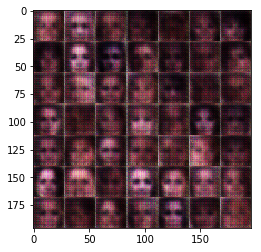

Epoch 1/1... Discriminator Loss: 0.0180... Generator Loss: 5.1220
Epoch 1/1... Discriminator Loss: 0.1316... Generator Loss: 2.8533
Epoch 1/1... Discriminator Loss: 0.9261... Generator Loss: 10.6503
Epoch 1/1... Discriminator Loss: 0.1812... Generator Loss: 2.3888
Epoch 1/1... Discriminator Loss: 0.1004... Generator Loss: 2.9470
Epoch 1/1... Discriminator Loss: 0.0117... Generator Loss: 14.7149
Epoch 1/1... Discriminator Loss: 0.0636... Generator Loss: 3.2794
Epoch 1/1... Discriminator Loss: 0.0231... Generator Loss: 4.3882
Epoch 1/1... Discriminator Loss: 0.0298... Generator Loss: 4.4951
Epoch 1/1... Discriminator Loss: 0.0230... Generator Loss: 5.9517


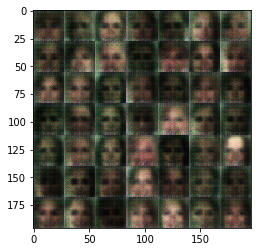

Epoch 1/1... Discriminator Loss: 0.0454... Generator Loss: 3.7929
Epoch 1/1... Discriminator Loss: 0.0542... Generator Loss: 4.1943
Epoch 1/1... Discriminator Loss: 0.0192... Generator Loss: 10.4493
Epoch 1/1... Discriminator Loss: 0.0150... Generator Loss: 8.7690
Epoch 1/1... Discriminator Loss: 0.0111... Generator Loss: 11.6792
Epoch 1/1... Discriminator Loss: 0.0397... Generator Loss: 3.8899
Epoch 1/1... Discriminator Loss: 0.0323... Generator Loss: 4.3316
Epoch 1/1... Discriminator Loss: 0.0210... Generator Loss: 10.6326
Epoch 1/1... Discriminator Loss: 0.0357... Generator Loss: 4.2954
Epoch 1/1... Discriminator Loss: 0.0294... Generator Loss: 4.4366


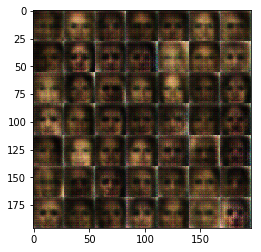

Epoch 1/1... Discriminator Loss: 9.1358... Generator Loss: 0.0030
Epoch 1/1... Discriminator Loss: 3.4391... Generator Loss: 0.0496
Epoch 1/1... Discriminator Loss: 0.1423... Generator Loss: 10.2828
Epoch 1/1... Discriminator Loss: 0.0432... Generator Loss: 7.2049
Epoch 1/1... Discriminator Loss: 0.2875... Generator Loss: 1.6703
Epoch 1/1... Discriminator Loss: 3.5498... Generator Loss: 13.1361
Epoch 1/1... Discriminator Loss: 0.0626... Generator Loss: 7.1273
Epoch 1/1... Discriminator Loss: 0.4475... Generator Loss: 1.2958
Epoch 1/1... Discriminator Loss: 0.4267... Generator Loss: 1.6338
Epoch 1/1... Discriminator Loss: 0.4126... Generator Loss: 1.4463


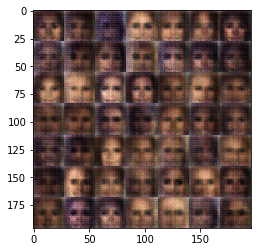

Epoch 1/1... Discriminator Loss: 0.0414... Generator Loss: 7.2633
Epoch 1/1... Discriminator Loss: 0.0156... Generator Loss: 5.8961
Epoch 1/1... Discriminator Loss: 0.0213... Generator Loss: 5.1526
Epoch 1/1... Discriminator Loss: 0.0028... Generator Loss: 13.8885
Epoch 1/1... Discriminator Loss: 0.4015... Generator Loss: 1.2769
Epoch 1/1... Discriminator Loss: 0.2760... Generator Loss: 1.7737
Epoch 1/1... Discriminator Loss: 0.0316... Generator Loss: 7.2602
Epoch 1/1... Discriminator Loss: 0.0091... Generator Loss: 9.7140
Epoch 1/1... Discriminator Loss: 0.0222... Generator Loss: 6.3013
Epoch 1/1... Discriminator Loss: 1.8690... Generator Loss: 12.2387


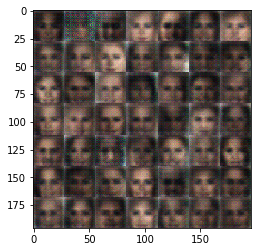

Epoch 1/1... Discriminator Loss: 0.0529... Generator Loss: 3.7781
Epoch 1/1... Discriminator Loss: 0.7704... Generator Loss: 15.6502
Epoch 1/1... Discriminator Loss: 0.0495... Generator Loss: 4.5733
Epoch 1/1... Discriminator Loss: 0.0037... Generator Loss: 9.9107
Epoch 1/1... Discriminator Loss: 8.0973... Generator Loss: 12.0183
Epoch 1/1... Discriminator Loss: 0.0119... Generator Loss: 7.1355
Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 9.3077
Epoch 1/1... Discriminator Loss: 0.2576... Generator Loss: 6.8175
Epoch 1/1... Discriminator Loss: 0.5644... Generator Loss: 1.0222
Epoch 1/1... Discriminator Loss: 0.0464... Generator Loss: 10.1223


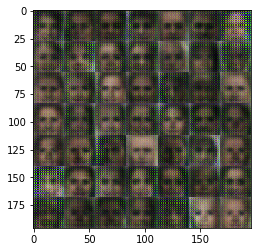

Epoch 1/1... Discriminator Loss: 0.0215... Generator Loss: 7.6440
Epoch 1/1... Discriminator Loss: 0.0257... Generator Loss: 5.1865
Epoch 1/1... Discriminator Loss: 0.0929... Generator Loss: 2.9241
Epoch 1/1... Discriminator Loss: 0.1568... Generator Loss: 2.2138
Epoch 1/1... Discriminator Loss: 0.0243... Generator Loss: 9.7303
Epoch 1/1... Discriminator Loss: 0.3530... Generator Loss: 8.4367
Epoch 1/1... Discriminator Loss: 0.0461... Generator Loss: 9.1226
Epoch 1/1... Discriminator Loss: 0.0082... Generator Loss: 7.2424
Epoch 1/1... Discriminator Loss: 0.0278... Generator Loss: 6.5677
Epoch 1/1... Discriminator Loss: 0.0092... Generator Loss: 8.6561


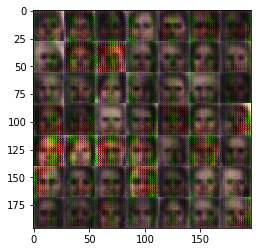

Epoch 1/1... Discriminator Loss: 0.0192... Generator Loss: 15.1022
Epoch 1/1... Discriminator Loss: 0.0283... Generator Loss: 13.1258
Epoch 1/1... Discriminator Loss: 0.0259... Generator Loss: 7.7523
Epoch 1/1... Discriminator Loss: 0.0048... Generator Loss: 7.2214
Epoch 1/1... Discriminator Loss: 0.0144... Generator Loss: 5.7026
Epoch 1/1... Discriminator Loss: 0.0064... Generator Loss: 11.1686
Epoch 1/1... Discriminator Loss: 0.0075... Generator Loss: 8.7741
Epoch 1/1... Discriminator Loss: 0.0084... Generator Loss: 9.3688
Epoch 1/1... Discriminator Loss: 0.0151... Generator Loss: 13.6577
Epoch 1/1... Discriminator Loss: 0.0137... Generator Loss: 6.3468


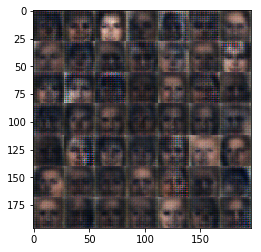

Epoch 1/1... Discriminator Loss: 0.0187... Generator Loss: 9.3049
Epoch 1/1... Discriminator Loss: 0.0015... Generator Loss: 9.4803
Epoch 1/1... Discriminator Loss: 0.2444... Generator Loss: 2.0339
Epoch 1/1... Discriminator Loss: 0.0048... Generator Loss: 7.8226
Epoch 1/1... Discriminator Loss: 0.0156... Generator Loss: 8.5716
Epoch 1/1... Discriminator Loss: 0.3774... Generator Loss: 1.4212
Epoch 1/1... Discriminator Loss: 0.0208... Generator Loss: 5.5932
Epoch 1/1... Discriminator Loss: 0.0182... Generator Loss: 6.0129
Epoch 1/1... Discriminator Loss: 0.0047... Generator Loss: 6.4681
Epoch 1/1... Discriminator Loss: 0.0183... Generator Loss: 5.2091


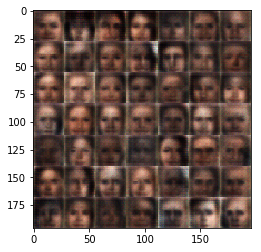

Epoch 1/1... Discriminator Loss: 0.0363... Generator Loss: 11.5233
Epoch 1/1... Discriminator Loss: 0.0575... Generator Loss: 4.9677
Epoch 1/1... Discriminator Loss: 0.0328... Generator Loss: 3.9425
Epoch 1/1... Discriminator Loss: 0.0091... Generator Loss: 7.1409
Epoch 1/1... Discriminator Loss: 0.0094... Generator Loss: 10.0726
Epoch 1/1... Discriminator Loss: 0.0147... Generator Loss: 8.5521
Epoch 1/1... Discriminator Loss: 0.0114... Generator Loss: 6.8761
Epoch 1/1... Discriminator Loss: 0.7943... Generator Loss: 9.0687
Epoch 1/1... Discriminator Loss: 0.0194... Generator Loss: 6.2346
Epoch 1/1... Discriminator Loss: 0.4704... Generator Loss: 1.2778


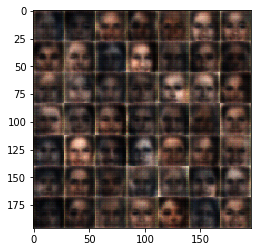

Epoch 1/1... Discriminator Loss: 0.2664... Generator Loss: 1.8229
Epoch 1/1... Discriminator Loss: 1.6790... Generator Loss: 10.5975
Epoch 1/1... Discriminator Loss: 0.0152... Generator Loss: 10.1059
Epoch 1/1... Discriminator Loss: 0.1719... Generator Loss: 5.3090
Epoch 1/1... Discriminator Loss: 2.5926... Generator Loss: 0.1211
Epoch 1/1... Discriminator Loss: 0.0362... Generator Loss: 7.4969
Epoch 1/1... Discriminator Loss: 0.0289... Generator Loss: 6.0307
Epoch 1/1... Discriminator Loss: 0.1135... Generator Loss: 2.8834
Epoch 1/1... Discriminator Loss: 0.0145... Generator Loss: 8.1480
Epoch 1/1... Discriminator Loss: 0.0533... Generator Loss: 4.9721


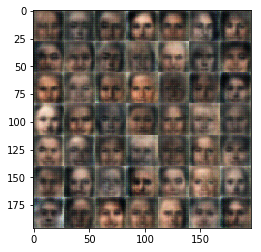

Epoch 1/1... Discriminator Loss: 0.0607... Generator Loss: 3.7195
Epoch 1/1... Discriminator Loss: 0.0932... Generator Loss: 2.9724
Epoch 1/1... Discriminator Loss: 0.2117... Generator Loss: 2.2086
Epoch 1/1... Discriminator Loss: 0.0157... Generator Loss: 9.6791
Epoch 1/1... Discriminator Loss: 0.0192... Generator Loss: 9.4910
Epoch 1/1... Discriminator Loss: 0.0185... Generator Loss: 4.7991
Epoch 1/1... Discriminator Loss: 0.0672... Generator Loss: 7.4903
Epoch 1/1... Discriminator Loss: 0.1358... Generator Loss: 2.6511
Epoch 1/1... Discriminator Loss: 0.0889... Generator Loss: 6.8268
Epoch 1/1... Discriminator Loss: 0.0572... Generator Loss: 8.8003


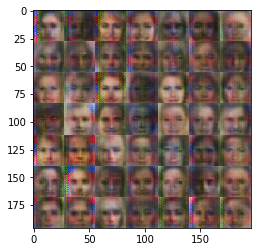

Epoch 1/1... Discriminator Loss: 1.1542... Generator Loss: 0.4981
Epoch 1/1... Discriminator Loss: 0.0554... Generator Loss: 4.3818
Epoch 1/1... Discriminator Loss: 0.2520... Generator Loss: 1.9541
Epoch 1/1... Discriminator Loss: 0.0266... Generator Loss: 8.7250
Epoch 1/1... Discriminator Loss: 0.0298... Generator Loss: 5.2271
Epoch 1/1... Discriminator Loss: 0.0177... Generator Loss: 8.6108
Epoch 1/1... Discriminator Loss: 0.2304... Generator Loss: 1.9273
Epoch 1/1... Discriminator Loss: 0.1558... Generator Loss: 2.4904
Epoch 1/1... Discriminator Loss: 0.0113... Generator Loss: 10.5842
Epoch 1/1... Discriminator Loss: 0.0089... Generator Loss: 7.2769


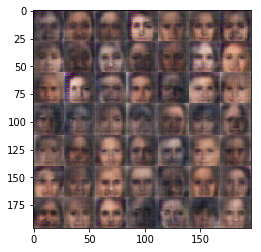

Epoch 1/1... Discriminator Loss: 0.0156... Generator Loss: 5.7035
Epoch 1/1... Discriminator Loss: 0.0068... Generator Loss: 9.6184
Epoch 1/1... Discriminator Loss: 0.0063... Generator Loss: 8.5313
Epoch 1/1... Discriminator Loss: 0.0133... Generator Loss: 11.7271
Epoch 1/1... Discriminator Loss: 0.0259... Generator Loss: 11.2962
Epoch 1/1... Discriminator Loss: 0.0113... Generator Loss: 5.5583
Epoch 1/1... Discriminator Loss: 0.0085... Generator Loss: 7.1531
Epoch 1/1... Discriminator Loss: 0.0027... Generator Loss: 9.8484


In [51]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.